In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from datetime import datetime, timedelta
from itertools import product

import utils

# read csv
bandwidth = pd.read_csv('data/bandwidth.csv')
bandwidth.columns = ['bandwidth']
# input hourly dates starting from 2019/01/01
inital_date = datetime(2000, 1, 1, 0, 0, 0)
hourly_delta = timedelta(hours=1)

hourly_dates = []
for i in range(bandwidth.shape[0]):
    hourly_dates.append((i * hourly_delta) + inital_date)
    
bandwidth['date'] = pd.to_datetime(hourly_dates)
bandwidth.set_index('date', inplace=True)
bandwidth.index.freq = 'H'

bandwidth['diff_bandwidth'] = bandwidth['bandwidth'].diff()

bandwidth.head()

,bandwidth,diff_bandwidth
date,,
2000-01-01 00:00:00,1000.496714,NaN
2000-01-01 01:00:00,1000.969408,0.472694
2000-01-01 02:00:00,1002.046019,1.076611
2000-01-01 03:00:00,1004.702118,2.656099
2000-01-01 04:00:00,1007.447816,2.745698


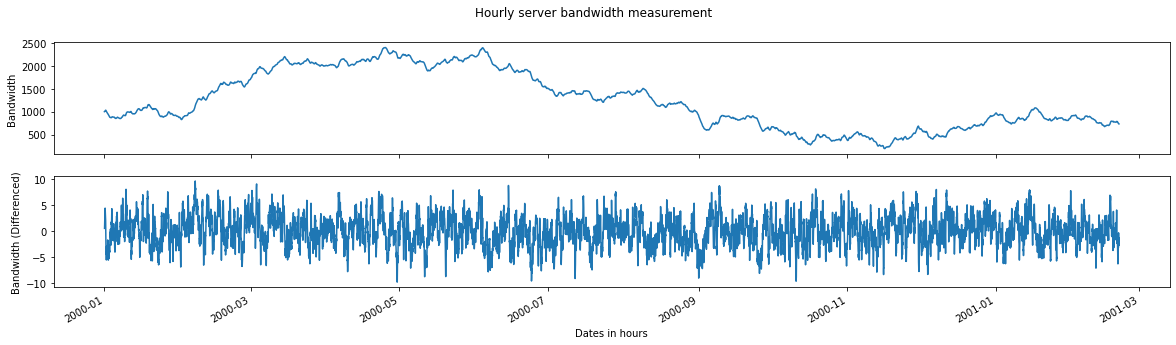

In [2]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20,5))
fig.suptitle('Hourly server bandwidth measurement')

ax1.plot(bandwidth['bandwidth'])
ax1.set_ylabel('Bandwidth')
ax1.set_xlabel('Hours')

ax2.plot(bandwidth['diff_bandwidth'])
ax2.set_ylabel('Bandwidth (Differenced)')
ax2.set_xlabel('Dates in hours')

fig.autofmt_xdate()
plt.show()

In [3]:
test_set_size = 168 # one week worth for forecasting

df = bandwidth[1:].copy()

train = df[:-test_set_size]
test = df[-test_set_size:]

print(len(train))
print(len(test))

9831
168


In [4]:
arima_order = (3, 0, 2)
arima_model = ARIMA(df.diff_bandwidth, order=arima_order).fit()
res = arima_model.resid
print(arima_model.aic, arima_model.sse)

28453.18946581494 10060.46443673856


In [5]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         diff_bandwidth   No. Observations:                 9999
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -14219.595
Date:                Sat, 28 Jan 2023   AIC                          28453.189
Time:                        18:39:37   BIC                          28503.661
Sample:                    01-01-2000   HQIC                         28470.274
                         - 02-20-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0274      0.123     -0.223      0.823      -0.268       0.213
ar.L1          0.3583      0.053      6.782      0.000       0.255       0.462
ar.L2          0.4102      0.066      6.185      0.000       0.280       0.540
ar.L3          0.0531      0.035      1.508      0.131      -0.016       0.122
ma.L1          0.8573      0.052     16.562      0.000       0.756       0.959
ma.L2          0.3247      0.030     10.843      0.000       0.266       0.383
sigma2         1.0061      0.014     71.157      0.000       0.978       1.034
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.98   Prob(JB):                         0.83
Heteroskedasticity (H):               1.04   Skew:                             0.00
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
prediction = arima_model.predict(len(test))
forecast = arima_model.forecast(len(test))

print(len(forecast), len(prediction))

168 9831


In [8]:
forecast

2001-02-20 16:00:00   -0.991091
2001-02-20 17:00:00   -0.855613
2001-02-20 18:00:00   -0.790771
2001-02-20 19:00:00   -0.691852
2001-02-20 20:00:00   -0.622611
                         ...   
2001-02-27 11:00:00   -0.027379
2001-02-27 12:00:00   -0.027379
2001-02-27 13:00:00   -0.027379
2001-02-27 14:00:00   -0.027379
2001-02-27 15:00:00   -0.027379
Freq: H, Name: predicted_mean, Length: 168, dtype: float64

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20,5))
fig.suptitle('Hourly server bandwidth measurement')

ax1.plot(bandwidth['bandwidth'])
ax1.set_ylabel('Bandwidth')
ax1.set_xlabel('Hours')

ax2.plot(bandwidth['diff_bandwidth'])
ax2.set_ylabel('Bandwidth (Differenced)')
ax2.set_xlabel('Dates in hours')

fig.autofmt_xdate()
plt.show()